In [1]:
#This is new Notebook Deep Embeddding Clustering fro visualisation check previous notebook

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_score


In [3]:
df=pd.read_csv('/kaggle/input/customer-segmentation-tutorial-in-python/Mall_Customers.csv')
df.shape

(200, 5)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


In [5]:
df = df.drop('CustomerID', axis=1)

In [6]:
df = df.drop('Gender', axis=1)

In [7]:
df = df.drop(df.tail(5).index)
df.shape

(195, 3)

In [8]:
# df['Gender'] = df['Gender'].map({'Male': 1, 'Female': 0})

In [9]:
df

,Age,Annual Income (k$),Spending Score (1-100)
0,19,15,39
1,21,15,81
2,20,16,6
3,23,16,77
4,31,17,40
...,...,...,...
190,34,103,23
191,32,103,69
192,33,113,8
193,38,113,91


In [10]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,195.0,38.953846,14.106477,18.0,28.0,36.0,49.0,70.0
Annual Income (k$),195.0,58.800000,24.122668,15.0,40.0,60.0,77.0,120.0
Spending Score (1-100),195.0,50.041026,25.756360,1.0,35.0,50.0,72.0,99.0


In [11]:
X=df

In [12]:
X.shape

(195, 3)

In [13]:
scaler = StandardScaler()
X= scaler.fit_transform(X)

In [14]:
X[1]

array([-1.27601378, -1.82039326,  1.20508734])

In [15]:
# Split
X_train, X_test = train_test_split(X, test_size=0.3, random_state=42)

In [16]:
X_train.shape, X_test.shape

((136, 3), (59, 3))

In [17]:
# Convert data to PyTorch tensors
X_tensor = torch.tensor(X, dtype=torch.float32)


In [18]:
class Autoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(Autoencoder, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, latent_dim)
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, input_dim)
        )

    def forward(self, x):
        latent = self.encoder(x)
        reconstructed = self.decoder(latent)
        return reconstructed, latent


In [19]:
# Model configuration
input_dim = X.shape[1]
latent_dim = 2
model = Autoencoder(input_dim, latent_dim)

# Optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

# Training loop
epochs = 300
for epoch in range(epochs):
    optimizer.zero_grad()
    reconstructed, latent = model(X_tensor)
    loss = criterion(reconstructed, X_tensor)
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 20 == 0:
        print(f'Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}')


Epoch [20/300], Loss: 0.3895
Epoch [40/300], Loss: 0.1799
Epoch [60/300], Loss: 0.1253
Epoch [80/300], Loss: 0.0778
Epoch [100/300], Loss: 0.0569
Epoch [120/300], Loss: 0.0474
Epoch [140/300], Loss: 0.0416
Epoch [160/300], Loss: 0.0376
Epoch [180/300], Loss: 0.0346
Epoch [200/300], Loss: 0.0320
Epoch [220/300], Loss: 0.0298
Epoch [240/300], Loss: 0.0279
Epoch [260/300], Loss: 0.0264
Epoch [280/300], Loss: 0.0251
Epoch [300/300], Loss: 0.0241


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


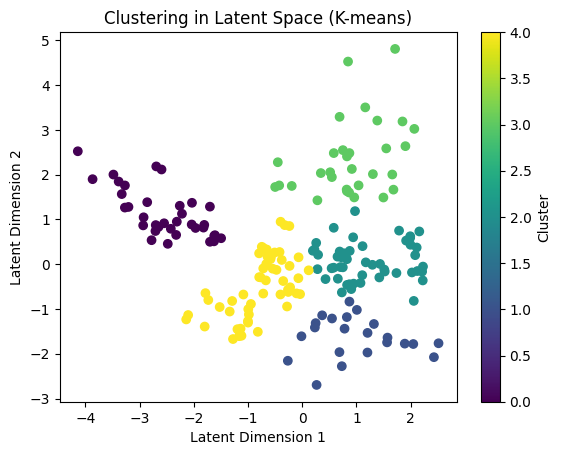

In [20]:
# Extract latent features
with torch.no_grad():
    latent_features = model.encoder(X_tensor).detach().numpy()

# Apply K-means clustering
kmeans = KMeans(n_clusters=5, random_state=42)
clusters = kmeans.fit_predict(latent_features)

# Visualize the clusters
plt.scatter(latent_features[:, 0], latent_features[:, 1], c=clusters, cmap='viridis', marker='o')
plt.title('Clustering in Latent Space (K-means)')
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.colorbar(label='Cluster')
plt.show()


In [21]:
class ClusteringLayer(nn.Module):
    def __init__(self, n_clusters, latent_dim):
        super(ClusteringLayer, self).__init__()
        self.n_clusters = n_clusters
        self.latent_dim = latent_dim
        self.centroids = nn.Parameter(torch.Tensor(n_clusters, latent_dim))
        nn.init.xavier_uniform_(self.centroids)

    def forward(self, x):
        q = 1.0 / (1.0 + torch.sum((x.unsqueeze(1) - self.centroids) ** 2, dim=2))
        q = (q.t() / torch.sum(q, dim=1)).t()
        return q

In [22]:
class DEC(nn.Module):
    def __init__(self, autoencoder, clustering_layer):
        super(DEC, self).__init__()
        self.autoencoder = autoencoder
        self.clustering_layer = clustering_layer

    def forward(self, x):
        _, latent = self.autoencoder(x)
        q = self.clustering_layer(latent)
        return q, latent

In [23]:
def target_distribution(q):
    p = q ** 2 / q.sum(0)
    p = (p.t() / p.sum(1)).t()
    return p

# Initialize DEC model
n_clusters = 4
clustering_layer = ClusteringLayer(n_clusters, latent_dim)
dec_model = DEC(model, clustering_layer)

# Optimizer
optimizer = optim.Adam(dec_model.parameters(), lr=0.001)

# DEC training
epochs = 200
for epoch in range(epochs):
    optimizer.zero_grad()
    
    q, latent = dec_model(X_tensor)
    
    # Target distribution
    p = target_distribution(q).detach()
    
    # KL divergence loss
    loss = torch.nn.functional.kl_div(q.log(), p, reduction='batchmean')
    
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 20 == 0:
        print(f'Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}')


Epoch [20/200], Loss: 0.0780
Epoch [40/200], Loss: 0.0832
Epoch [60/200], Loss: 0.0847
Epoch [80/200], Loss: 0.0860
Epoch [100/200], Loss: 0.0875
Epoch [120/200], Loss: 0.0889
Epoch [140/200], Loss: 0.0902
Epoch [160/200], Loss: 0.0918
Epoch [180/200], Loss: 0.0934
Epoch [200/200], Loss: 0.0948


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


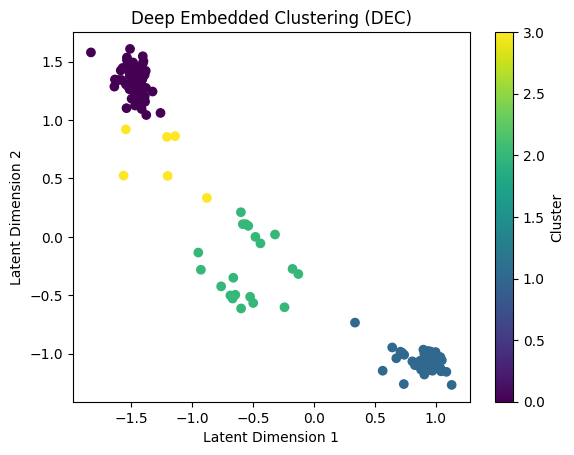

In [24]:
# Extract latent features
with torch.no_grad():
    _, latent_features = dec_model(X_tensor)

# Apply K-means clustering
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(latent_features)

# Plot clusters
plt.scatter(latent_features[:, 0], latent_features[:, 1], c=clusters, cmap='viridis')
plt.title('Deep Embedded Clustering (DEC)')
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.colorbar(label='Cluster')
plt.show()
